In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
files = [f for f in listdir("data") if isfile(join("data", f))]
data = []
for file in files:
    with open("data/" + file, "r", encoding='utf-8') as f:
        data += json.load(f)
cleaned = [entry for entry in data if entry[2] < 0] # remove those entries where the ball is flying in the direction of the opponent because we don't do anything in that case anyway.

In [3]:
copy = cleaned.copy()
for entry in copy:
    action = entry[6]
    if action == [1, 0, 0]:
        entry[6] = 'nothing'
    elif action == [0, 1, 0]:
        entry[6] = 'up'
    else:
        entry[6] = 'down'
raw_data = np.array(copy)

In [4]:
data = {'ballX': raw_data[:,0], 'ballY': raw_data[:,1], 'velocityX': raw_data[:,2], 'velocityY': raw_data[:,3], 'paddlePos1': raw_data[:,4], 'paddlePos2': raw_data[:,5], 'action': raw_data[:,6]}
df = pd.DataFrame(data)
df.head()

,ballX,ballY,velocityX,velocityY,paddlePos1,paddlePos2,action
0,0.5,0.5,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
1,0.48125,0.4566987298107781,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
2,0.4625,0.4133974596215561,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
3,0.4437499999999999,0.37009618943233424,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing
4,0.42499999999999993,0.3267949192431123,-0.5000000000000004,-0.8660254037844385,0.5,0.5,nothing


In [5]:
df.dtypes

ballX         object
ballY         object
velocityX     object
velocityY     object
paddlePos1    object
paddlePos2    object
action        object
dtype: object

In [6]:
df.ballX = df.ballX.astype(np.float32)
df.ballY = df.ballY.astype(np.float32)
df.velocityX = df.velocityX.astype(np.float32)
df.velocityY = df.velocityY.astype(np.float32)
df.paddlePos1 = df.paddlePos1.astype(np.float32)
df.paddlePos2 = df.paddlePos2.astype(np.float32)
df.action = df.action.astype('category')

In [7]:
df.dtypes

ballX          float32
ballY          float32
velocityX      float32
velocityY      float32
paddlePos1     float32
paddlePos2     float32
action        category
dtype: object

<AxesSubplot:>

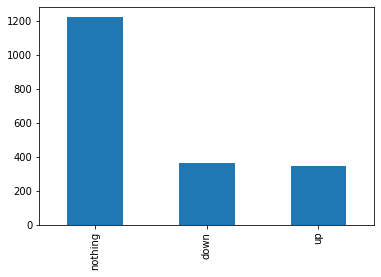

In [8]:
df.action.value_counts().plot(kind='bar')

In [9]:
df_majority = df[df.action == 'nothing']
df_minority1 = df[df.action == 'up']
df_minority2 = df[df.action == 'down']
print(df_majority.shape)
print(df_minority1.shape)
print(df_minority2.shape)
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples=len(df_minority1),
                                 random_state=42)
df = pd.concat([df_majority_downsampled, df_minority1, df_minority2])
df.action.value_counts()

(1221, 7)
(346, 7)
(363, 7)


down       363
up         346
nothing    346
Name: action, dtype: int64

<AxesSubplot:>

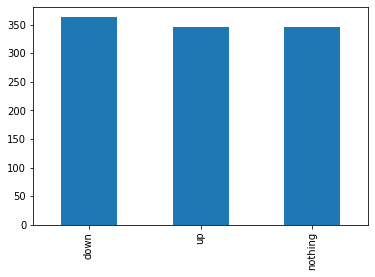

In [10]:
df.action.value_counts().plot(kind='bar')

In [11]:
X = df.drop('action', 1)
y = df['action']

In [12]:
X.head()

,ballX,ballY,velocityX,velocityY,paddlePos1,paddlePos2
878,0.500000,0.500000,-0.939693,-0.342020,0.500000,0.500000
413,0.391858,0.458654,-0.961262,-0.275637,0.500000,0.500000
75,0.968750,0.803109,-0.500000,0.866025,0.666667,0.666667
1622,0.088905,0.255958,-0.913545,-0.406737,0.250000,0.250000
1208,0.838646,0.392099,-0.694658,-0.719340,0.541667,0.541667


In [13]:
y.head()

878     nothing
413     nothing
75      nothing
1622    nothing
1208    nothing
Name: action, dtype: category
Categories (3, object): ['down', 'nothing', 'up']

In [14]:
y.values

['nothing', 'nothing', 'nothing', 'nothing', 'nothing', ..., 'down', 'down', 'down', 'down', 'down']
Length: 1055
Categories (3, object): ['down', 'nothing', 'up']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[-0.8274886 , -0.25488177, -1.3991463 , -0.04858106, -0.37722465,
        -0.37722465],
       [-0.04080316, -0.39001167, -1.0098118 , -0.5940143 , -0.19350986,
        -0.19350986],
       [-0.4452511 , -1.1320022 , -0.02550229, -1.0490594 ,  1.6436371 ,
         1.6436371 ],
       ...,
       [ 1.2838287 ,  1.6257343 ,  0.6206854 , -1.2281241 ,  0.90877813,
         0.90877813],
       [-1.4228243 ,  1.3018696 ,  0.46828625, -1.1907568 ,  1.8273518 ,
         1.8273518 ],
       [ 0.12878363, -0.32342294, -1.0098118 , -0.5940143 , -0.00979522,
        -0.00979522]], dtype=float32)

In [108]:
scaler.scale_

array([0.20643864, 0.2690903 , 0.1702066 , 0.62503627, 0.22680095,
       0.22680095])

In [109]:
scaler.mean_

array([ 0.33337702,  0.51535638, -0.76170378,  0.01291252,  0.50222157,
        0.50222157])

In [17]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.32701421800947866

In [18]:
estimator_KNN = KNeighborsClassifier(algorithm='auto')

In [19]:
parameters_KNN = {
    'n_neighbors': (1, 2, 4, 8, 10, 12, 16, 24),
    'leaf_size': (1, 4, 8, 12, 16, 20),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')}
                   
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'f1_micro',
    n_jobs = -1,
    cv = 5
)
grid_search_KNN.fit(X_train, y_train)
print(grid_search_KNN.best_params_ )
print('Best Score - KNN:', grid_search_KNN.best_score_ )

{'leaf_size': 12, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Score - KNN: 0.8175542406311637


In [20]:
knn = KNeighborsClassifier(leaf_size=12, metric='minkowski', n_neighbors=1, p=1, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=12, n_neighbors=1, p=1)

In [21]:
y_pred = grid_search_KNN.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print ("test accuracy score: %.2f" % accuracy)
print ("test f1 score: %.2f" % f1)

test accuracy score: 0.78
test f1 score: 0.78


In [23]:
random_forest = RandomForestClassifier(random_state=42)
parameters_RandomForest = {
    'n_estimators': [10, 25, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [1, 4, 8, 16]
}
                   
grid_search_RandomForest = GridSearchCV(
    estimator=random_forest,
    param_grid=parameters_RandomForest,
    scoring = 'f1_micro',
    n_jobs = -1,
    cv = 5
)
grid_search_RandomForest.fit(X_train, y_train)
print(grid_search_RandomForest.best_params_ )
print('Best Score - Random Forest:', grid_search_RandomForest.best_score_ )

{'max_features': 0.25, 'min_samples_split': 4, 'n_estimators': 250}
Best Score - Random Forest: 0.8033882783882784


In [24]:
y_pred = grid_search_RandomForest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print ("test accuracy score: %.2f" % accuracy)
print ("test f1 score: %.2f" % f1)

test accuracy score: 0.79
test f1 score: 0.79


In [25]:
!pip install auto-sklearn

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 36, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Andrin\AppData\Local\Temp\pip-install-_yxqy9p4\auto-sklearn_412bcbc121c54243807873afac0b70bd\setup.py", line 13, in <module>
      sys.platform
  ValueError: Detected unsupported operating system: win32. Please check the compability information of auto-sklearn: https://automl.github.io/auto-sklearn/master/installation.html#windows-osx-compatibility
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.


  Using cached auto-sklearn-0.14.7.tar.gz (6.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'



error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [26]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
automl = AutoSklearn2Classifier(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=8)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", accuracy_score(y_test, y_hat))

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [39]:
y_train.head()

610    nothing
420       down
444         up
73          up
121         up
Name: action, dtype: category
Categories (3, object): ['down', 'nothing', 'up']

In [41]:
y_train_cat = pd.get_dummies(y_train)
y_train_cat.head()

,down,nothing,up
610,0,1,0
420,1,0,0
444,0,0,1
73,0,0,1
121,0,0,1


In [ ]:
classifier = Sequential()
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 3, activation = 'softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = classifier.fit(X_train, y_train_cat, epochs=300)

In [60]:
y_test_cat = pd.get_dummies(y_test)
y_test_cat.head()

,down,nothing,up
861,0,1,0
747,1,0,0
801,1,0,0
1606,1,0,0
1232,0,1,0


In [61]:
results = classifier.evaluate(X_test, y_test_cat)

7/7 [==============================] - 0s 2ms/step - loss: 0.7177 - accuracy: 0.6635


In [63]:
classifier.get_weights()

[array([[ 1.5399314 , -2.8293917 ,  2.525134  , -2.1885777 ],
        [-0.42994532,  1.8620425 ,  0.1342129 , -1.9561486 ],
        [-1.4407576 , -1.4305859 ,  0.16285542, -1.7758865 ],
        [ 0.93223983,  0.28353357,  0.09982148, -0.1016136 ],
        [-0.9442277 , -0.02171859, -0.03981543,  0.37959537],
        [-0.7063211 , -1.2678899 , -1.2025316 ,  1.0569857 ]],
       dtype=float32),
 array([ 0.18150555, -0.644038  ,  0.09577676, -0.6265329 ], dtype=float32),
 array([[-2.1102998 , -0.46727428,  2.0454555 ],
        [-5.9539576 , -0.01119816,  3.4104886 ],
        [ 0.835805  ,  1.6214173 , -1.3059618 ],
        [ 4.1843863 ,  0.36222976, -7.352658  ]], dtype=float32),
 array([ 1.4740968,  0.0601493, -1.5465372], dtype=float32)]

In [157]:
class TinyNN():
    def __init__(self):
        self.input = None
        self.layers = []
        
    def set_input(self, input):
        self.input = input
    
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def feed_forward(self, x):
        state = self.input.transform(x)
        for layer in self.layers:
            state = layer.feed_forward(state)
        return state

In [96]:
class TinyInput():
    def __init__(self, normalization):
        self.normalization = normalization
        
    def transform(self, input_values):
        return self.normalization.apply(input_values)

In [98]:
class TinyActivation():
    def compute(self, values):
        pass

In [99]:
class TinyReLU():
    def compute(self, values):
        outputs = []
        for value in values:
            output = max(0, value)
            outputs.append(output)
        return outputs

[0.18150554597377777,
 -0.6440380215644836,
 0.0957767590880394,
 -0.6265329122543335]

In [100]:
relu = TinyReLU()
relu.compute([-4.3, 4923])

[0, 4923]

In [101]:
import math
class TinySoftmax():
    def compute(self, values):
        exped = [math.exp(value) for value in values]
        total_exp = sum(exped)
        outputs = []
        for value in values:
            logit_exp = math.exp(value)
            output = logit_exp / total_exp
            outputs.append(output)
        return outputs

In [102]:
softmax = TinySoftmax()
result = softmax.compute([0, 9, 4])
print(result)
print(sum(result))

[0.00012256881570915678, 0.9931854005948174, 0.006692030589473348]
0.9999999999999999


In [103]:
class Normalization():
    def apply(self, unnormalized):
        pass

In [110]:
class ZScoreNormalization():
    def __init__(self, mus, sigmas):
        self.mus = mus
        self.sigmas = sigmas
    
    def apply(self, unnormalized):
        normalized = []
        param_index = 0
        for value in unnormalized:
            output = (value - self.mus[param_index]) / self.sigmas[param_index]
            normalized.append(output)
            param_index += 1
        return normalized

In [114]:
z_score = ZScoreNormalization(mus=scaler.mean_, sigmas=scaler.scale_)
z_score.apply([300, 12, 45])

[1451.6014506651468, 42.67951469817707, 268.8597416346911]

In [124]:
X_train.values[0].tolist()

[0.6838156580924988,
 0.03873118758201599,
 -0.5446390509605408,
 -0.838670551776886,
 0.4583333432674408,
 0.4583333432674408]

In [160]:
class TinyDenseLayer():
    def __init__(self, units, weights, biases, activation):
        self.units = units
        self.weights = weights
        self.biases = biases
        self.activation = activation
        
    def feed_forward(self, inputs):
        source_neuron_index = 0
        all_zs = []
        for _ in range(self.units):
            weight_index = 0
            total_weights = 0
            for source_neuron in inputs:
                weight = self.weights[weight_index][source_neuron_index]
                total_weights += weight * source_neuron
                weight_index += 1
            z = total_weights + self.biases[source_neuron_index]
            all_zs.append(z)
            source_neuron_index += 1
        return self.activation.compute(all_zs)

In [140]:
t = df.values[0].copy()[:-1]
t

array([0.5, 0.5, -0.9396926164627075, -0.3420201539993286, 0.5, 0.5],
      dtype=object)

In [168]:
tnorm = scaler.transform([t])

In [169]:
tnorm

array([[ 0.80713078, -0.05706775, -1.04572227, -0.56785932, -0.00979522,
        -0.00979522]])

In [170]:
classifier.predict(tnorm)

array([[0.0121673, 0.7346086, 0.2532241]], dtype=float32)

In [172]:
def z_score_to_config(mus, sigmas):
    return { "type": "z_score", "mus": mus, "sigmas": sigmas }

In [179]:
def layer_to_config(units, weights, biases, activation):
    return { "units": units, "weights": weights, "biases": biases , "activation": activation}

In [203]:
z_score_to_config(scaler.mean_.tolist(), scaler.scale_.tolist())

{'type': 'z_score',
 'mus': [0.33337702376600264,
  0.5153563783685589,
  -0.7617037799827295,
  0.012912516517485205,
  0.5022215660378972,
  0.5022215660378972],
 'sigmas': [0.20643863564542597,
  0.2690903048652044,
  0.17020660475885124,
  0.6250362669552798,
  0.22680095198489916,
  0.22680095198489916]}

In [204]:
layer_1_config = layer_to_config(units=4, weights=classifier.get_weights()[0].tolist(), biases=classifier.get_weights()[1].tolist(), activation="relu")
layer_2_config = layer_to_config(units=3, weights=classifier.get_weights()[2].tolist(), biases=classifier.get_weights()[3].tolist(), activation="softmax")
print(layer_2_config)

{'units': 3, 'weights': [[-2.110299825668335, -0.4672742784023285, 2.0454554557800293], [-5.953957557678223, -0.011198162101209164, 3.4104886054992676], [0.8358049988746643, 1.6214172840118408, -1.3059618473052979], [4.184386253356934, 0.36222976446151733, -7.352657794952393]], 'biases': [1.4740967750549316, 0.06014930456876755, -1.546537160873413], 'activation': 'softmax'}


In [215]:
import json
json_config = json.dumps(final_config)

In [216]:
with open('pong_action_classifier_tiny_nn.json', 'w', encoding='utf-8') as f:
    json.dump(json_config, f, ensure_ascii=False, indent=4)

In [213]:
final_config = {
 "name": "pong_action_classifier",
  "version": "0.1",
  "input": {
          "normalization": z_score_to_config(scaler.mean_.tolist(), scaler.scale_.tolist())
  },
  "layers": [
      layer_1_config,
      layer_2_config
  ]
}
final_config

{'name': 'pong_action_classifier',
 'version': '0.1',
 'input': {'normalization': {'type': 'z_score',
   'mus': [0.33337702376600264,
    0.5153563783685589,
    -0.7617037799827295,
    0.012912516517485205,
    0.5022215660378972,
    0.5022215660378972],
   'sigmas': [0.20643863564542597,
    0.2690903048652044,
    0.17020660475885124,
    0.6250362669552798,
    0.22680095198489916,
    0.22680095198489916]}},
 'layers': [{'units': 4,
   'weights': [[1.5399314165115356,
     -2.8293917179107666,
     2.5251340866088867,
     -2.188577651977539],
    [-0.42994531989097595,
     1.8620425462722778,
     0.1342128962278366,
     -1.956148624420166],
    [-1.4407576322555542,
     -1.4305858612060547,
     0.16285541653633118,
     -1.7758865356445312],
    [0.932239830493927,
     0.28353357315063477,
     0.09982147812843323,
     -0.1016136035323143],
    [-0.9442276954650879,
     -0.0217185877263546,
     -0.03981543332338333,
     0.3795953691005707],
    [-0.706321120262146,
  

In [207]:
def nn_from_config(conf):
    nn = TinyNN()
    inputs = TinyInput(normalization=ZScoreNormalization(mus=conf['input']['normalization']['mus'], sigmas=conf['input']['normalization']['sigmas']))
    nn.set_input(inputs)
    for layer_config in conf['layers']:
        activation_func = None
        if layer_config['activation'] == 'relu':
            activation_func = TinyReLU()
        else:
            activation_func = TinySoftmax()
        dense_layer = TinyDenseLayer(units=layer_config['units'], weights=layer_config['weights'], biases=layer_config['biases'], activation=activation_func)
        nn.add_layer(dense_layer)
    return nn

In [208]:
nnz = nn_from_config(final_config)

In [209]:
nnz.feed_forward(t.tolist())

[0.012167297976847055, 0.7346085954192233, 0.2532241066039296]

In [210]:
class PongActionClassifier():
    def __init__(self, nn, class_names):
        self.nn = nn
        self.class_names = class_names
        
    def classify(self, inputs):
        outputs = self.nn.feed_forward(inputs)
        index_max = max(range(len(outputs)), key=outputs.__getitem__)
        return self.class_names[index_max]

In [211]:
action_classifier = PongActionClassifier(nnz, ["down", "up", "nothing"])
action_classifier.classify(t.tolist())

'up'

In [217]:
t.tolist()

[0.5, 0.5, -0.9396926164627075, -0.3420201539993286, 0.5, 0.5]

In [162]:
nn.feed_forward(t.tolist())

[0.012167297976847055, 0.7346085954192233, 0.2532241066039296]

In [141]:
scaler.transform([t])

array([[ 0.80713078, -0.05706775, -1.04572227, -0.56785932, -0.00979522,
        -0.00979522]])

In [142]:
z_score.apply(t.tolist())

[0.8071307762379566,
 -0.05706775045742111,
 -1.0457222663724044,
 -0.5678593215811085,
 -0.009795223602258799,
 -0.009795223602258799]

In [218]:
scaler.mean_.tolist()

[0.33337702376600264,
 0.5153563783685589,
 -0.7617037799827295,
 0.012912516517485205,
 0.5022215660378972,
 0.5022215660378972]

In [219]:
scaler.scale_.tolist()

[0.20643863564542597,
 0.2690903048652044,
 0.17020660475885124,
 0.6250362669552798,
 0.22680095198489916,
 0.22680095198489916]